Titanic Machine Learning from Disaster

Many people start machine learning projects from this Kaggle Competition, so do I. Although Kaggle is usually from better structured dataset, 
I still think it's a very good training platform as well as a good place to gain data science experience on EDA, feature engineering, and machine learning by learning from so many experts around the world.

Classifier/Label:
Survived. 1: Yes. 0: No

Features:
Pclass: Ticket class. 1 = 1st, 2 = 2nd, 3 = 3rd
Name
Sex
Age
SibSp: # of siblings / spouses aboard the Titanic
Parch: # of parents / children aboard the Titanic
Ticket: Ticket number
Fare: Ticket price
Cabin: Cabin number
Embarded: Port of Embarkation. C = Cherbourg, Q = Queenstown, S = Southampton

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline

df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

Check how the data look like:

In [2]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Remove 'PassengerId' and the label 'Survived':

Remove 'PassengerId'

In [3]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The chart below shows the statistics of number of survivers accross different Pclass values. 1 means survived and 0 means not survived.
We can see that the higher (better) the class is, the survival rate is higher. i.e. The survived rate is: Pclass1 > Pclass2 > Pclass3.
It's obvious that there are high correlations between Pclass and survival rate.

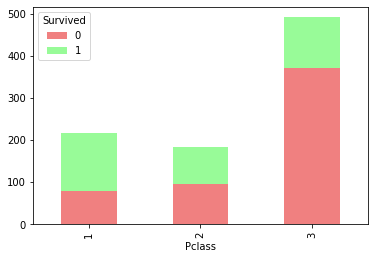

In [5]:
color = ['lightcoral', 'palegreen']
df_train.pivot_table(values = 'PassengerId', index = 'Pclass', columns = 'Survived',aggfunc = 'count')\
.plot(kind = 'bar', stacked = True, color = color)

It's obvious that passengers who were in higher class = 1 has higher probability to survive. It's probably because that better priorities
or facilities on higher class to make passengers survived.

Now compare the probabilities of survivals for female and male.
It's also clear that female has much lower survival rate than it on male passengers! It perhaps explains that female has higher priority to be rescued than male, but I guess that it's only true for adults, not kids. Let's check the next figure.

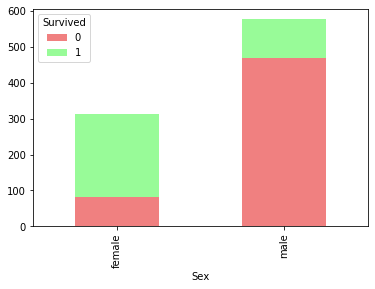

In [6]:
color = ['lightcoral', 'palegreen']
df_train.pivot_table(values = 'PassengerId', index = 'Sex', columns = 'Survived', aggfunc = 'count')\
.plot(kind= 'bar', stacked = True, color = color)

This figure below proves my guess! i.e. There is no bias on girls and boys under age 10.

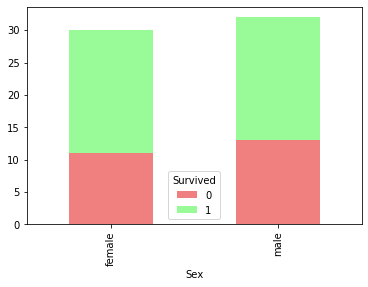

In [7]:
color = ['lightcoral', 'palegreen']
df_train[df_train['Age'] < 10].pivot_table(values = 'PassengerId', index = 'Sex', columns = 'Survived', aggfunc = 'count')\
.plot(kind= 'bar', stacked = True, color = color)

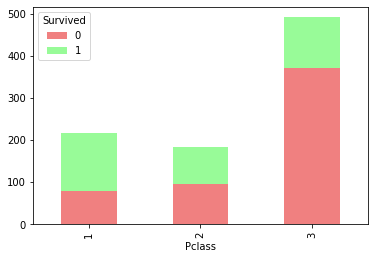

In [8]:
color = ['lightcoral', 'palegreen']
df_train.pivot_table(values = 'PassengerId', index = 'Pclass', columns = 'Survived', aggfunc = 'count')\
.plot(kind= 'bar', stacked = True, color = color)

Now take a look for the distributions between Embarded places (i.e. Port of Embarkation from the three ports) and the survival rates.

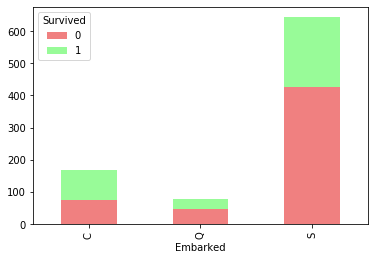

In [9]:
color = ['lightcoral', 'palegreen']
df_train.pivot_table(values = 'PassengerId', index = 'Embarked', columns = 'Survived', aggfunc = 'count')\
.plot(kind= 'bar', stacked = True, color = color)

From the chart above, it seems that passengers embarked from C (Cherbourg) have higher survival rate? Perhaps embarked place cannot explain cause and effect. The embarked places might be correlated to other features. From the chart below, the percentage of Pclass from Cherbourg is highest among the three cities. It might explain this result according to earlier observations on Pclass vs. Survival rate. 

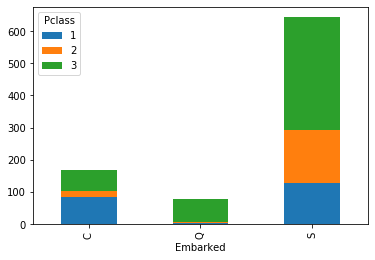

In [10]:
df_train.pivot_table(values = 'PassengerId', index = 'Embarked', columns = 'Pclass', aggfunc = 'count')\
.plot(kind= 'bar', stacked = True)

The Kernel Density Estimate (KDE) below for Age shows that youger ages (below around 35) have higher survival rate and older ages have lower sruvival rate.

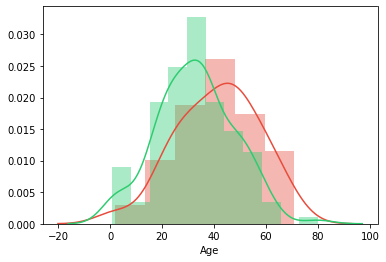

In [11]:
df = df_train.dropna(inplace = False) # Dropping nan values is just for observing original data, will asign values to the missing items.
surv = df['Survived'] == 1  
sns.distplot(df[~surv]['Age'], label='Not Survived', hist=True, color='#e74c3c')
sns.distplot(df[surv]['Age'], label='Survived', hist=True, color='#2ecc71')

The KDE for Fare shows that passengers with higher fare of tickets have higher surval rate. The distribution is right skewed with high fare of ourliers.

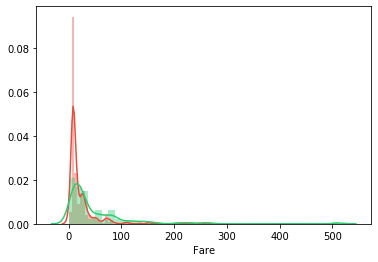

In [12]:
surv = df_train['Survived'] == 1  
sns.distplot(df_train[~surv]['Fare'], label='Not Survived', hist=True, color='#e74c3c')
sns.distplot(df_train[surv]['Fare'], label='Survived', hist=True, color='#2ecc71')

From the heatmap below, the Pearson's correlation value between Pclass and Fare is highest in all the features (-0.5).

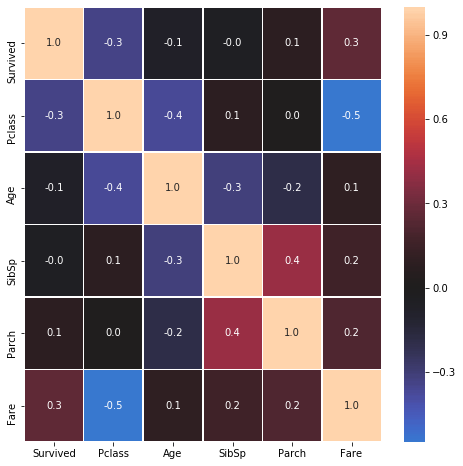

In [13]:
df = df_train.drop('PassengerId', axis = 1, inplace = False)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, center = 0)

In [14]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:]    

In [15]:
df_all = concat_df(df_train, df_test)
# Drop PassengerId
df_all.drop('PassengerId', axis = 1, inplace = True)

In [16]:
print('Missing data count on training set: ', df_train.isnull().sum())
print('Missing data count on test set: ', df_test.isnull().sum())

Missing data count on training set:  PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Missing data count on test set:  PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [17]:
df_all['Name'].value_counts()

Kelly, Mr. James                                                   2
Connolly, Miss. Kate                                               2
Gill, Mr. John William                                             1
de Messemaeker, Mr. Guillaume Joseph                               1
Denbury, Mr. Herbert                                               1
Nysten, Miss. Anna Sofia                                           1
Sincock, Miss. Maude                                               1
Carrau, Mr. Francisco M                                            1
Frost, Mr. Anthony Wood "Archie"                                   1
Riordan, Miss. Johanna Hannah""                                    1
McCarthy, Mr. Timothy J                                            1
Krekorian, Mr. Neshan                                              1
Walcroft, Miss. Nellie                                             1
Johnston, Master. William Arthur Willie""                          1
Holverson, Mrs. Alexander Oskar (M

In [18]:
df_all['Title'] = df_all['Name'].str.extract('([A-Za-z]+)\.', expand = False)
df_all[df_all['Title'].isnull()]
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')
df_all['Title'].value_counts()

Mr                          757
Miss/Mrs/Ms                 464
Master                       61
Dr/Military/Noble/Clergy     26
Countess                      1
Name: Title, dtype: int64

In [19]:
Sex_mapping = {'male': 0, 'female': 1}
df_all['Sex'] = df_all['Sex'].map(Sex_mapping)

In [20]:
# Fill in missing Age values
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [21]:
df_all['Family_size'] = df_all['SibSp'] + df_all['Parch'] + 1
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_group'] = df_all['Family_size'].map(family_map)

In [22]:
# Find in the missing value for Fare
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Family_size,Family_group
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,0,0,NaN,3701,Mr,1,Alone


In [23]:
# Fill in the missing value for Fare with class 3 median fare
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

In [24]:
df_all['Fare_per_person'] = df_all['Fare']/df_all['Family_size']
# Scalling - No impact on tree related algorithms such as Random Forest and Gradient Boosting. Has positive impact on Logistic Regression.
df_all['Fare'] = StandardScaler().fit_transform(df_all['Fare'].values.reshape(-1, 1))
df_all['Fare_per_person'] = StandardScaler().fit_transform(df_all['Fare_per_person'].values.reshape(-1, 1))

In [25]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])

In [26]:
df_all['Cabin'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'N')

In [27]:
# Find the missing data in 'Embarded'
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Family_size,Family_group,Fare_per_person
61,38.0,B,NaN,0.903334,"Icard, Miss. Amelie",0,1,1,0,1.0,113572,Miss/Mrs/Ms,1,Alone,1.664157
829,62.0,B,NaN,0.903334,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,1,0,1.0,113572,Miss/Mrs/Ms,1,Alone,1.664157


In [28]:
# Fill out the missing values in 'Embarked'
df_all['Embarked'].fillna('S', inplace = True)

One-hot encoding

In [29]:
df_all[['Sex','Pclass', 'Title', 'Cabin', 'Embarked']] = df_all[['Sex', 'Pclass', 'Title', 'Cabin', 'Embarked']].astype(str)
one_hot = pd.get_dummies(df_all[['Sex', 'Pclass', 'Title', 'Cabin', 'Embarked']])
print('one hot columns ', one_hot.columns)

one hot columns  Index(['Sex_0', 'Sex_1', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Countess',
       'Title_Dr/Military/Noble/Clergy', 'Title_Master', 'Title_Miss/Mrs/Ms',
       'Title_Mr', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_N', 'Cabin_T', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')


Separate train and test set

In [30]:
df_train, df_test = divide_df(df_all)
one_hot_train, one_hot_test = divide_df(one_hot)

print('Size of training set" ', df_train.shape)
print('Columns of training set: ', df_train.columns)
print('Size of test set: ', df_test.shape)
print('Columns of test set: ', df_test.columns)

print('Columns of training set after one-hot: ', one_hot_train.columns)
print('Columns of set set after one-hot: ', one_hot_test.columns)

Size of training set"  (891, 15)
Columns of training set:  Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Ticket', 'Title', 'Family_size', 'Family_group',
       'Fare_per_person'],
      dtype='object')
Size of test set:  (418, 15)
Columns of test set:  Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Ticket', 'Title', 'Family_size', 'Family_group',
       'Fare_per_person'],
      dtype='object')
Columns of training set after one-hot:  Index(['Sex_0', 'Sex_1', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Countess',
       'Title_Dr/Military/Noble/Clergy', 'Title_Master', 'Title_Miss/Mrs/Ms',
       'Title_Mr', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_N', 'Cabin_T', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')
Columns of set set after one-hot:  Index(['Sex_0', 'Sex_1', 'Pclass_1', 'Pclass_2', 'Pcl

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

survived = df_train['Survived']

# Apply Wrap method - Forward selection
# Better performance for Fare instead of Fare_per_person on decision tree related algorithms
X_train = df_train[['Age', 'Fare', 'Family_size']]
X_test = df_test[['Age', 'Fare', 'Family_size']]
X_train = pd.concat([X_train, one_hot_train], axis = 1)
X_test = pd.concat([X_test, one_hot_test], axis = 1)

print('All X_train columns ', X_train.columns)
print(X_train.isnull().sum())
print(survived.shape)
print('X_train shape=', X_train.shape)


print(survived)
print(X_train.columns)
print('X_test shape=',X_test.shape)
print(X_test.columns)
print(type(X_train))

All X_train columns  Index(['Age', 'Fare', 'Family_size', 'Sex_0', 'Sex_1', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Title_Countess', 'Title_Dr/Military/Noble/Clergy',
       'Title_Master', 'Title_Miss/Mrs/Ms', 'Title_Mr', 'Cabin_A', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_N',
       'Cabin_T', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')
Age                               0
Fare                              0
Family_size                       0
Sex_0                             0
Sex_1                             0
Pclass_1                          0
Pclass_2                          0
Pclass_3                          0
Title_Countess                    0
Title_Dr/Military/Noble/Clergy    0
Title_Master                      0
Title_Miss/Mrs/Ms                 0
Title_Mr                          0
Cabin_A                           0
Cabin_B                           0
Cabin_C                           0
Cabin_D            

In [32]:
# add standard scaler
print(X_train.shape)
col = X_train.columns
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = col)
print(type(X_train))
print(X_train.shape)
print(X_train.head())

col = X_test.columns
scaler = StandardScaler()
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = col)

print(type(X_test))
print(X_test.shape)
print(X_test.head())

from sklearn.decomposition import PCA
X_train
pca = PCA(n_components = 17, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

(891, 25)
<class 'pandas.core.frame.DataFrame'>
(891, 25)
        Age      Fare  Family_size     Sex_0     Sex_1  Pclass_1  Pclass_2  \
0 -0.539232 -0.502445     0.059160  0.737695 -0.737695 -0.565685 -0.510152   
1  0.661032  0.786845     0.059160 -1.355574  1.355574  1.767767 -0.510152   
2 -0.239166 -0.488854    -0.560975 -1.355574  1.355574 -0.565685 -0.510152   
3  0.435982  0.420730     0.059160 -1.355574  1.355574  1.767767 -0.510152   
4  0.435982 -0.486337    -0.560975  0.737695 -0.737695 -0.565685 -0.510152   

   Pclass_3  Title_Countess  Title_Dr/Military/Noble/Clergy  ...   Cabin_C  \
0  0.902587        -0.03352                       -0.155364  ... -0.266296   
1 -1.107926        -0.03352                       -0.155364  ...  3.755222   
2  0.902587        -0.03352                       -0.155364  ... -0.266296   
3 -1.107926        -0.03352                       -0.155364  ...  3.755222   
4  0.902587        -0.03352                       -0.155364  ... -0.266296   

    

In [33]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=5, include_bias=False)
poly.fit(X_train)
X_poly = poly.transform(X_train)

In [34]:
from sklearn.linear_model import LogisticRegression

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_poly, survived, test_size = 0.3, random_state = 42)

clf = LogisticRegression(C = 0.05, solver = 'lbfgs', max_iter = 5000)
LogReg = clf.fit(X_train_t, y_train_t)
score = LogReg.score(X_train_t, y_train_t)
print('Logistic Regression score on training set ', score)

score = LogReg.score(X_test_t, y_test_t)
print('Logistic Regression score on CV ', score)

Logistic Regression score on training set  0.9181380417335474
Logistic Regression score on CV  0.7761194029850746


In [35]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
score = cross_val_score(clf, X_poly, survived, cv=k_fold)
print("Logistic Regression k-fold cross validation scores:\n", score)
print('Logistic Regression k-fold average score: ', round(np.mean(score)*100, 2))

Logistic Regression k-fold cross validation scores:
 [0.80446927 0.80337079 0.82022472 0.79213483 0.74719101]
Logistic Regression k-fold average score:  79.35


In [36]:
# Algorithms which do not need polynomial features
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train, survived, test_size = 0.3, random_state = 42)

In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion='gini', 
                                n_estimators=800,
                                           max_depth=3,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features= 'auto',
                                           oob_score=True,
                                           random_state=42,
                                           n_jobs=-1,
                                           verbose=1)

rf = clf.fit(X_train_t, y_train_t)
score = rf.score(X_train_t, y_train_t)
print('Random Forest score on training set ', score)
score = rf.score(X_test_t, y_test_t)
print('Random Forest score on test set ', score)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.0s finished


Random Forest score on training set  0.8234349919743178


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.0s finished


Random Forest score on test set  0.8246268656716418


In [38]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
score = cross_val_score(clf, X_train, survived, cv=k_fold)
print("Random Forest k-fold cross validation scores:\n", score)
print('Random Forest k-fold average score: ', round(np.mean(score)*100, 2))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elap

Random Forest k-fold cross validation scores:
 [0.82681564 0.79213483 0.80337079 0.8258427  0.83707865]
Random Forest k-fold average score:  81.7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.0s finished


In [39]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state = 42, max_depth = 1, learning_rate = 0.15, max_features = 14, min_samples_leaf = 12)

gb = clf.fit(X_train_t, y_train_t)
score = gb.score(X_train_t, y_train_t)

print('Gradient Boost score on training set ', score)
score = gb.score(X_test_t, y_test_t)
print('Gradient Boost score of test set on train.csv', score)

Gradient Boost score on training set  0.8346709470304976
Gradient Boost score on CV  0.835820895522388


In [40]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
score = cross_val_score(clf, X_train, survived, cv=k_fold)
print("Gradient Boost k-fold scores on train.csv:\n", score)
print('Gradient Boost k-fold average score on train.csv: ', round(np.mean(score)*100, 2))

Gradient Boost cross validation scores:
 [0.81005587 0.81460674 0.83146067 0.8258427  0.84831461]
Gradient Boost k-fold average score:  82.61


In [41]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', random_state = 42, hidden_layer_sizes=[2,1], alpha = 1, max_iter=1000)
nn = clf.fit(X_train_t, y_train_t)
score = nn.score(X_train_t, y_train_t)
print('NN MLP score on training set ', score)
score = nn.score(X_test_t, y_test_t)
print('NN MLP score of test set on train.csv ', score)

NN MLP score on training set  0.8651685393258427
NN MLP score on CV  0.7985074626865671


In [42]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
score=cross_val_score(clf, X_train, survived, cv=k_fold)
print("NN MLP k-fold scores:\n", score)
print('NN MLP k-fold average score on train.csv: ', round(np.mean(score)*100, 2))

NN MLP cross validation scores:
 [0.81005587 0.8258427  0.8258427  0.83146067 0.81460674]
NN MLP k-fold average score:  82.16


In [43]:
# PCA score
score=cross_val_score(clf, X_train_pca, survived, cv=k_fold)
print("NN MLP k-fold scores:\n", score)
print('NN MLP k-fold average score on train.csv: ', round(np.mean(score)*100, 2))

NN MLP cross validation scores:
 [0.81564246 0.8258427  0.83146067 0.83146067 0.54494382]
NN MLP k-fold average score:  76.99


Apply Neural Network model to test.csv for prediction and Kaggle submission.

In [44]:
pred = gb.predict(X_test)
np.savetxt('code submission.csv', pred)